In [3]:
# since you first have to create a virtual environment it get created with no jupyter notebooks preinstalled, so:
# pip install --user ipykernel - this install the jupyter kernel 
# python -m ipykernel install --user --name=myenv - this creates the environment as kernel
#I think there is no need to do have a virtual environment heret since it's just a notebook with analysis, 

In [18]:

from chessdotcom import client, get_player_game_archives
from datetime import datetime
import pprint
import requests
import pandas as pd

username = 'chiopra'

printer = pprint.PrettyPrinter()

def print_stats(username):
    data = client.get_player_stats(username, tts=0)
    printer.pprint(data.json)



### A/B Test: Playing more than 4 games per day leads to better results

In [19]:
dates = []
results = []

def appending_results(values):
    if values['result'] == 'win':
        results.append('win')
    elif values['result'] == 'draw':
        results.append('draw')
    else:
        results.append('loss')
    return results

def get_games(username):
    data = get_player_game_archives(username)
    for key,value in data.json.items():
        for url in value:
            games = requests.get(url).json()
            for game in games['games']:
                for k, v in game.items():
                    if k == 'end_time':
                        date = datetime.utcfromtimestamp(v).strftime('%Y-%m-%d')
                        dates.append(date)
                    if k == 'white' and v['username'] == 'chiopra':
                        results = appending_results(v)
                    elif k == 'black' and v['username'] == 'chiopra':
                        results = appending_results(v)
    return dates, results

dates, results = get_games(username)


#                 if game['time_class'] == 'rapid':
#                     for k, v in game.items():
#                         print(k)
                #for tomorrow just the date and the result, loss or win to df and then do aggregate function to get wins/losses per day
#                 print(type(game))
#                 df = pd.DataFrame.from_dict(game, orient = 'columns')
#                 print(df)
#                 print
#                 print(df.columns)
#                 string = df['pgn'].to_string(index=False)
#                 print(string)
#                 for i in string.split('"'):
#                     print(i)
#                 break;
#             break;
              
    # for i in data['Archives']:
    #     print(i)
    # printer.pprint(data.json)

# get_games(username)

# print(requests.get('https://www.chess.com/game/live/1221711014').content())

In [23]:
import numpy as np

df = pd.DataFrame({'dates': dates,
                   'results': results})

In [24]:
#I think that it works and doesn't work sometimes because of this warning

# C:\Users\ModestasMotiejunas\AppData\Local\Temp\ipykernel_22844\870220668.py:17: SettingWithCopyWarning: 
# A value is trying to be set on a copy of a slice from a DataFrame.
# Try using .loc[row_indexer,col_indexer] = value instead

# See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
#   df_test_sub['games per day'] = df_test_sub.groupby(['dates'])['count'].sum()

In [25]:
import duckdb 

In [ ]:
# Run these pip install commands from the command line if Jupyter Notebook is not yet installed.
# Otherwise, see Google Collab link above for an in-notebook example
pip install duckdb

# Install Jupyter Notebook (Note: you can also install JupyterLab: pip install jupyterlab) 
pip install notebook

# Install supporting libraries
pip install jupysql
pip install duckdb-engine
pip install pandas       # conda install pandas (in case pip fails)
pip install matplotlib

In [26]:
%load_ext sql

The sql extension is already loaded. To reload it, use:
  %reload_ext sql


In [27]:
%config SqlMagic.autopandas = True
%config SqlMagic.feedback = False
%config SqlMagic.displaycon = False

In [28]:
%sql duckdb:///:memory:

,5
0,5


In [58]:
#without \ you could not have separate rows for sql script
%sql df_agg << WITH fully AS \
(SELECT *,cast(count(dates) as float) as count \
FROM df GROUP BY dates, results), \
sub as \
(SELECT dates, cast(count(dates) as float) as games \
FROM df GROUP BY dates) \
select f.*, s.games, (f.count/s.games)*100 as percentage from fully f \
left join sub s on s.dates = f.dates \
where f.results = 'win' and games > 1 and games < 18



In [71]:
df_agg.head()
# print(df_agg['games'].sum())

,dates,results,count,games,percentage
0,2020-07-13,win,5.0,11.0,45.454548
1,2020-07-15,win,2.0,7.0,28.571430
2,2020-12-01,win,1.0,3.0,33.333336
3,2020-12-03,win,3.0,5.0,60.000004
4,2020-12-04,win,2.0,2.0,100.000000


In [60]:
%sql df_average << select games, avg(percentage) \
from df_agg \
group by games

In [68]:
%sql df_count << select games, count(games) \
from df_agg \
group by games

In [76]:
%sql df_overall_avg << select sum(count)/sum(games)*100 as overall \
from df_agg 


In [77]:
df_overall_avg.head()

,overall
0,52.952953


In [61]:
df_average.head()

,games,avg(percentage)
0,11.0,51.515153
1,7.0,50.649353
2,3.0,43.333337
3,5.0,46.666668
4,2.0,68.750000


<BarContainer object of 15 artists>

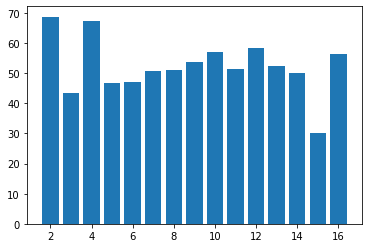

In [62]:
import matplotlib.pyplot as plt

plt.bar(df_average['games'], df_average['avg(percentage)'])

<BarContainer object of 15 artists>

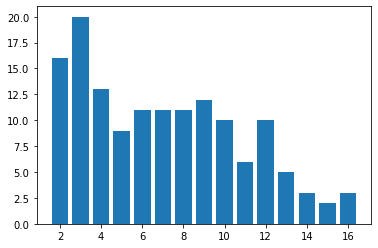

In [69]:
import matplotlib.pyplot as plt

plt.bar(df_count['games'], df_count['count(games)'])